## K-Means Clustering on Frailty
#### By Gavin Qu, Aug 11th 2024

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [108]:
df = pd.read_csv('/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_long_panel.csv')

In [126]:
df.head(2)

,pidp,age_dv,disdif1,disdif2,disdif3,disdif4,disdif5,disdif6,disdif7,disdif8,...,healthcond9,healthcond10,healthcond11,healthcond12,healthcond13,healthcond14,healthcond15,healthcond16,death,frailty
0,22445,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.037037
1,22445,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.037037


In [124]:
df_frailty = df[['pidp', 'wave', 'age_dv', 'death', 'frailty']]
df_frailty = df_frailty[df_frailty['age_dv'].isin([50.0, 52.0, 54.0, 56.0, 58.0, 60.0])]
df_frailty.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54324 entries, 89 to 537902
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   pidp     54324 non-null  int64  
 1   wave     54324 non-null  object 
 2   age_dv   54324 non-null  float64
 3   death    54324 non-null  int64  
 4   frailty  53681 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.5+ MB


In [127]:
df_frailty.describe()

,pidp,age_dv,death,frailty
count,5.432400e+04,54324.000000,54324.000000,53681.000000
mean,7.755209e+08,54.804396,0.003313,0.058183
std,4.659261e+08,3.407268,0.057468,0.096125
min,9.567650e+05,50.000000,0.000000,0.000000
25%,4.080177e+08,52.000000,0.000000,0.000000
50%,7.480830e+08,54.000000,0.000000,0.037037
75%,1.157156e+09,58.000000,0.000000,0.074074
max,1.653209e+09,60.000000,1.000000,1.000000


In [131]:
# Create a dictionary to map age to new column names
age_to_col = {50: 'frailty_50', 52: 'frailty_52', 54: 'frailty_54', 
              56: 'frailty_56', 58: 'frailty_58', 60: 'frailty_60'}

# Create a new column 'frailty_age' based on the age
df_frailty['frailty_age'] = df_frailty['age_dv'].map(age_to_col)

# Pivot the dataframe
df_wide = df_frailty.pivot(index='pidp', columns='frailty_age', values='frailty')

# Reset the index to make 'pidp' a column
df_wide.reset_index(inplace=True)

# Rename columns if they don't match the desired format
df_wide.columns.name = None

# If you want to keep other variables that don't vary with age (like 'death'),
# you can merge them back in. For example:
other_vars = df_frailty.groupby('pidp')['death'].first().reset_index()
df_wide = pd.merge(df_wide, other_vars, on='pidp', how='left')

# Remove rows where all frailty values are NaN
frailty_columns = ['frailty_50', 'frailty_52', 'frailty_54', 'frailty_56', 'frailty_58', 'frailty_60']
df_wide = df_wide.dropna(subset=frailty_columns, how='all')

# Display the first few rows of the resulting dataframe
print(df_wide.head())

# Display the shape of the dataframe
print(f"Shape of the dataframe: {df_wide.shape}")

      pidp  frailty_50  frailty_52  frailty_54  frailty_56  frailty_58  \
1  1587125    0.000000    0.000000    0.000000         NaN         NaN   
2  1833965    0.000000    0.037037         NaN         NaN         NaN   
3  2817245    0.000000         NaN         NaN         NaN         NaN   
4  3229325    0.074074         NaN         NaN         NaN         NaN   
5  3621685         NaN         NaN    0.074074         NaN         NaN   

   frailty_60  death  
1         NaN      0  
2         NaN      0  
3         NaN      0  
4         NaN      0  
5         NaN      0  
Shape of the dataframe: (20028, 8)


### K-means Implementation
We will treat health trajectory of each person over the clustering period as a vector, then remove those with NaN values.

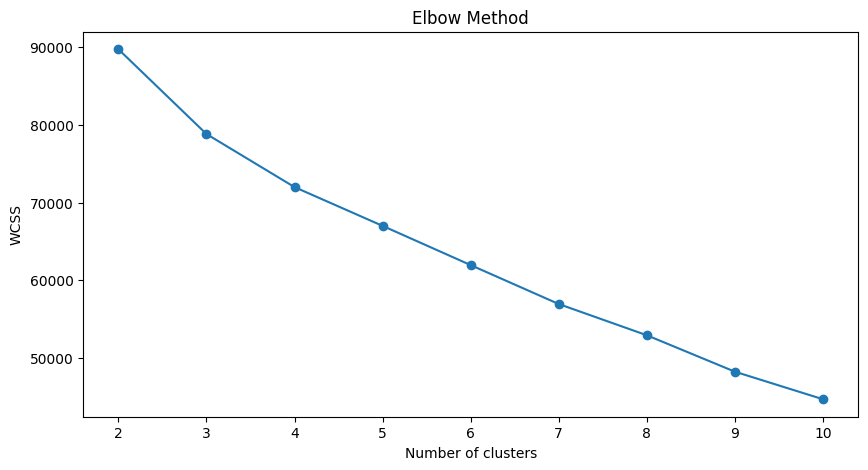

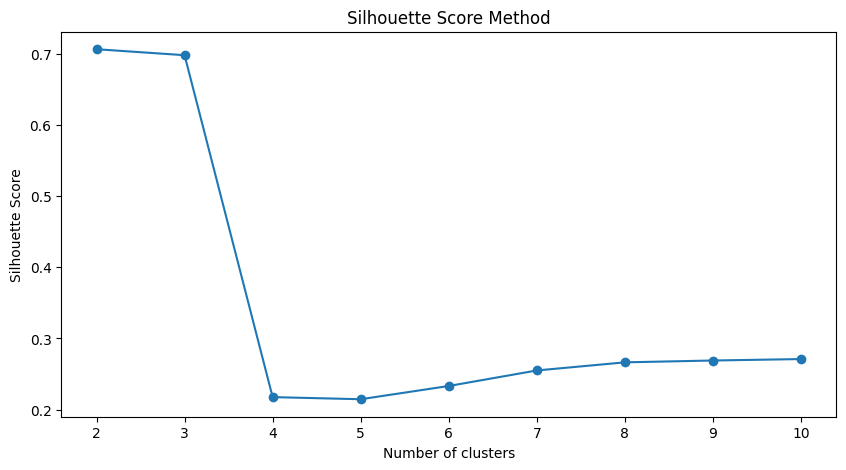

The optimal number of clusters based on the highest silhouette score is: 2
      pidp  frailty_50  frailty_52  frailty_54  frailty_56  frailty_58  \
1  1587125    0.000000    0.000000    0.000000         NaN         NaN   
2  1833965    0.000000    0.037037         NaN         NaN         NaN   
3  2817245    0.000000         NaN         NaN         NaN         NaN   
4  3229325    0.074074         NaN         NaN         NaN         NaN   
5  3621685         NaN         NaN    0.074074         NaN         NaN   

   frailty_60  death  Cluster  
1         NaN      0        0  
2         NaN      0        0  
3         NaN      0        0  
4         NaN      0        0  
5         NaN      0        0  

Cluster Centroids:
   frailty_50  frailty_52  frailty_54  frailty_56  frailty_58  frailty_60
0    0.038415    0.041246    0.046206    0.050940    0.057800    0.065033
1    0.132641    0.161203    0.182554    0.189159    0.198432    0.181806


In [132]:
# Select only the frailty columns for clustering
frailty_columns = ['frailty_50', 'frailty_52', 'frailty_54', 'frailty_56', 'frailty_58', 'frailty_60']
X = df_wide[frailty_columns]

# Handle missing values (if any)
X = X.fillna(X.mean())

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Function to compute Within-Cluster-Sum-of-Squares (WCSS)
def compute_wcss(data):
    wcss = []
    for n in range(2, 11):
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)
    return wcss

# Compute WCSS for different numbers of clusters
wcss = compute_wcss(X_scaled)

# Plot the Elbow Curve
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Compute silhouette scores for different numbers of clusters
silhouette_scores = []
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Determine the optimal number of clusters
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"The optimal number of clusters based on the highest silhouette score is: {optimal_clusters}")

# Perform K-means clustering with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans_optimal.fit_predict(X_scaled)

# Add cluster labels to the original dataframe
df_wide['Cluster'] = cluster_labels

# Display the first few rows of the resulting dataframe
print(df_wide.head())

# Display cluster centroids
centroids = scaler.inverse_transform(kmeans_optimal.cluster_centers_)
centroid_df = pd.DataFrame(centroids, columns=frailty_columns)
print("\nCluster Centroids:")
print(centroid_df)

#### Elbow Method
The elbow method plot shows the relationship between the number of clusters (k) and the inertia (within-cluster sum of squares). Here's how to interpret it:
1) Look for an "elbow" point in the plot where the rate of decrease sharply changes.
2) This point represents a good balance between cluster coherence and number of clusters.
3) After this point, adding more clusters doesn't significantly reduce inertia.

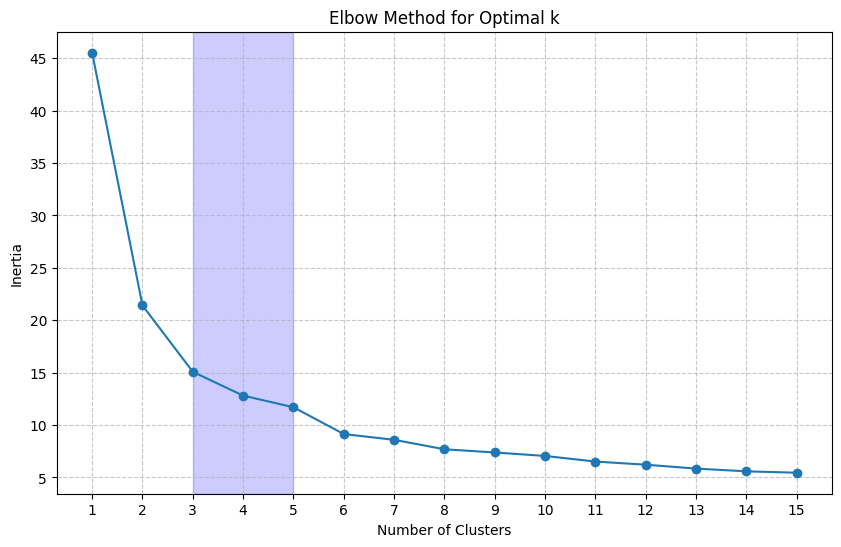

In [44]:
def elbow_method(X, max_clusters=15, highlight_range=(3, 5)):
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = kmeans_clustering(X, k)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    
    # Add shaded region
    plt.axvspan(highlight_range[0], highlight_range[1], alpha=0.2, color='blue')
    
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.xticks(range(1, max_clusters + 1))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Assuming X_scaled is your scaled data
elbow_method(X_scaled)

#### Silhouette Method
The silhouette method measures how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1, where higher values indicate better-defined clusters. 

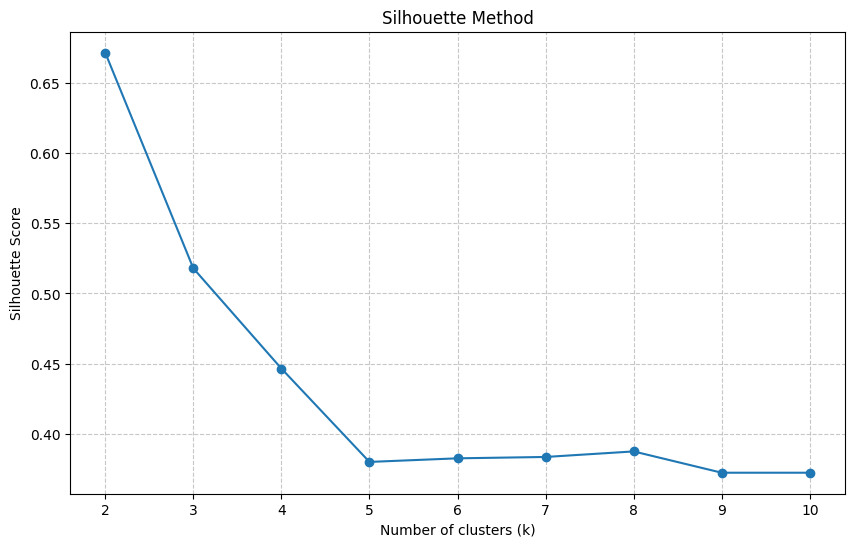

In [45]:
def silhouette_method(X, max_clusters=10):
    silhouette_scores = []
    for k in range(2, max_clusters + 1):  # Start from 2 clusters
        kmeans = kmeans_clustering(X, k)
        score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(score)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(2, max_clusters + 1))
    plt.show()

silhouette_method(X_scaled)

### Economic Interpretations
*Skip for now*

Elbow method: Decent decrease in loss criterion from 2 to 3 clusters, with smaller decreases after 3 clusters.
Silhouette method: Big decreases in loss criterion until k=5, so we should opt for k=4 clusters as a midpoint. 

### Rerun K Means algo with Optimal K = 3

In [133]:
# Select only the frailty columns for clustering
frailty_columns = ['frailty_50', 'frailty_52', 'frailty_54', 'frailty_56', 'frailty_58', 'frailty_60']
X = df_wide[frailty_columns]

# Handle missing values (if any)
X = X.fillna(X.mean())

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering with K=3
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataframe
df_wide['Cluster'] = cluster_labels

# Display the first few rows of the resulting dataframe
print(df_wide.head())

# Display cluster centroids
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroid_df = pd.DataFrame(centroids, columns=frailty_columns)
print("\nCluster Centroids:")
print(centroid_df)

# Calculate the size of each cluster
cluster_sizes = df_wide['Cluster'].value_counts().sort_index()
print("\nCluster Sizes:")
print(cluster_sizes)

# Calculate the mean frailty scores for each cluster
cluster_means = df_wide.groupby('Cluster')[frailty_columns].mean()
print("\nMean Frailty Scores by Cluster:")
print(cluster_means)

# Save the results
df_wide.to_csv('frailty_clusters.csv', index=False)
print("\nResults saved to 'frailty_clusters.csv'")

      pidp  frailty_50  frailty_52  frailty_54  frailty_56  frailty_58  \
1  1587125    0.000000    0.000000    0.000000         NaN         NaN   
2  1833965    0.000000    0.037037         NaN         NaN         NaN   
3  2817245    0.000000         NaN         NaN         NaN         NaN   
4  3229325    0.074074         NaN         NaN         NaN         NaN   
5  3621685         NaN         NaN    0.074074         NaN         NaN   

   frailty_60  death  Cluster  
1         NaN      0        0  
2         NaN      0        0  
3         NaN      0        0  
4         NaN      0        0  
5         NaN      0        0  

Cluster Centroids:
   frailty_50  frailty_52  frailty_54  frailty_56  frailty_58  frailty_60
0    0.037414    0.040739    0.046352    0.051119    0.057392    0.064300
1    0.218416    0.229182    0.204356    0.125323    0.099004    0.085277
2    0.060987    0.090331    0.136451    0.220649    0.275596    0.267732

Cluster Sizes:
Cluster
0    18477
1      742
2

#### Merging frailty_clusters.csv on frailty_long_panel

In [134]:
original_df = pd.read_csv('/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_long_panel.csv')

# Load the clustering results (assuming we saved it in the previous step)
cluster_df = pd.read_csv('frailty_clusters.csv')

# Keep only 'pidp' and 'Cluster' columns from the clustering results
cluster_df = cluster_df[['pidp', 'Cluster']]

# Add 1 to Cluster values to make them 1-3 instead of 0-2
cluster_df['Cluster'] = cluster_df['Cluster'] + 1

# Merge the cluster information with the original dataset
merged_df = original_df.merge(cluster_df[['pidp', 'Cluster']], on='pidp', how='left')

# Fill NaN values in the Cluster column with 0 (for PIDs not included in the clustering)
merged_df['Cluster'] = merged_df['Cluster'].fillna(0).astype(int)

# Print some information about the merged dataset
print("Shape of the merged dataset:", merged_df.shape)
print("\nNumber of unique PIDs:", merged_df['pidp'].nunique())
print("\nDistribution of Cluster values:")
print(merged_df['Cluster'].value_counts(normalize=True))

# Save the merged dataset
output_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_long_panel_with_clusters.csv'
merged_df.to_csv(output_path, index=False)
print(f"\nMerged dataset saved to: {output_path}")

# Display the first few rows of the merged dataset
print("\nFirst few rows of the merged dataset:")
print(merged_df.head())

Shape of the merged dataset: (537920, 95)

Number of unique PIDs: 89601

Distribution of Cluster values:
Cluster
0    0.662658
1    0.309405
3    0.014722
2    0.013216
Name: proportion, dtype: float64

Merged dataset saved to: /Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_long_panel_with_clusters.csv

First few rows of the merged dataset:
    pidp  age_dv  disdif1  disdif2  disdif3  disdif4  disdif5  disdif6  \
0  22445    27.0      NaN      NaN      NaN      NaN      NaN      NaN   
1  22445    28.0      NaN      NaN      NaN      NaN      NaN      NaN   
2  22445    29.0      NaN      NaN      NaN      NaN      NaN      NaN   
3  22445    30.0      NaN      NaN      NaN      NaN      NaN      NaN   
4  22445    31.0      0.0      0.0      0.0      0.0      0.0      0.0   

   disdif7  disdif8  ...  healthcond10  healthcond11  healthcond12  \
0      NaN      NaN  ...           0.0           0.0           0.0   
1      NaN      NaN  ...           0.0       

We will further filter it by only including individuals with cluster 1, 2, and 3. 

In [138]:
df_clustering = pd.read_csv('/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_long_panel_with_clusters.csv')

# Filter the dataframe to include only the specified variables and clusters 1-3
df_filtered = df_clustering[['Cluster', 'pidp', 'age_dv', 'frailty', 'death', 'wave']]
df_filtered = df_filtered[df_filtered['Cluster'].isin([1, 2, 3])]

# Display information about the filtered dataframe
print("Shape of the filtered dataframe:", df_filtered.shape)
print("\nColumns in the filtered dataframe:")
print(df_filtered.columns.tolist())

# Display the first few rows of the filtered dataframe
print("\nFirst few rows of the filtered dataframe:")
print(df_filtered.head())

# Display summary statistics
print("\nSummary statistics of the filtered dataframe:")
print(df_filtered.describe())

# Check for missing values
print("\nMissing values in each column:")
print(df_filtered.isnull().sum())

# Display the distribution of clusters
print("\nDistribution of clusters:")
print(df_filtered['Cluster'].value_counts(normalize=True))

# Save the filtered dataframe
output_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_clustering_filtered_valid_clusters.csv'
df_filtered.to_csv(output_path, index=False)
print(f"\nFiltered dataset saved to: {output_path}")

Shape of the filtered dataframe: (181463, 6)

Columns in the filtered dataframe:
['Cluster', 'pidp', 'age_dv', 'frailty', 'death', 'wave']

First few rows of the filtered dataframe:
     Cluster     pidp  age_dv  frailty  death wave
96         1  1587125    48.0      0.0      0    f
97         1  1587125    49.0      0.0      0    g
98         1  1587125    50.0      0.0      0    h
99         1  1587125    51.0      0.0      0    i
100        1  1587125    52.0      0.0      0    j

Summary statistics of the filtered dataframe:
             Cluster          pidp         age_dv        frailty  \
count  181463.000000  1.814630e+05  181463.000000  181463.000000   
mean        1.126456  7.697829e+08      54.520293       0.058399   
std         0.444685  4.648225e+08       6.948696       0.097870   
min         1.000000  1.587125e+06      38.000000       0.000000   
25%         1.000000  3.545833e+08      49.000000       0.000000   
50%         1.000000  7.072714e+08      54.000000       0

### Descriptive Stats and Plots

Describing the characteristics of each of your K=4 clusters i.e. show their: 
- Average Frailty trajectories as in the figure below from De Nardi et al
- Employment status – e.g. you could show what fraction of each cluster are employed and inactive by age
- Earnings status – average earnings of each cluster by age

#### Useful Numbers before and after clustering

In [142]:
# Count total unique individuals
total_unique = df_filtered['pidp'].nunique()
print("Total number of unique individuals:", total_unique)

# Count unique individuals in each cluster
unique_per_cluster = df_filtered.groupby('Cluster')['pidp'].nunique()
print("\nNumber of unique individuals in each cluster:")
for cluster, count in unique_per_cluster.items():
    print(f"Cluster {cluster}: {count} ({count/total_unique:.2%})")

# Get age range
print(f"\nAge range: {df_filtered['age_dv'].min()} to {df_filtered['age_dv'].max()}")

# Get age range for each cluster
age_range_per_cluster = df_filtered.groupby('Cluster')['age_dv'].agg(['min', 'max'])
print("\nAge range for each cluster:")
print(age_range_per_cluster)

Total number of unique individuals: 20028

Number of unique individuals in each cluster:
Cluster 1: 18477 (92.26%)
Cluster 2: 742 (3.70%)
Cluster 3: 809 (4.04%)

Age range: 38.0 to 72.0

Age range for each cluster:
          min   max
Cluster            
1        38.0  72.0
2        38.0  64.0
3        44.0  72.0


**The following plot effectively illustrates different health dynamics across various health types (clusters), both during and after the clustering period.**

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_94427/3193990387.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = df_filtered.groupby(['age_bins', 'Cluster'])['frailty'].mean().unstack()


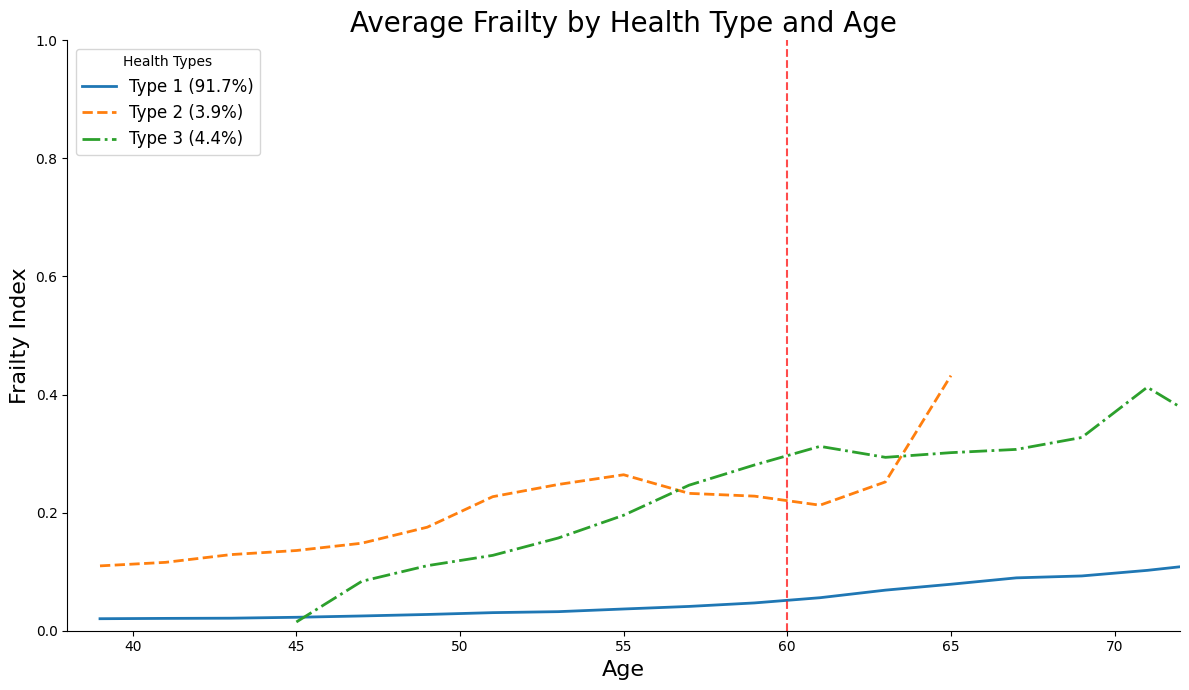

Plot saved as 'frailty_by_age_and_cluster.png'


<Figure size 640x480 with 0 Axes>

In [141]:
# Filter out rows with NaN values in frailty or Cluster
df_filtered = df_filtered[~np.isnan(df_filtered['frailty']) & ~np.isnan(df_filtered['Cluster'])]

# Create age bins
df_filtered['age_bins'] = pd.cut(df_filtered['age_dv'], bins=range(38, 75, 2), right=False)

# Calculate mean frailty for each bin and cluster
binned_data = df_filtered.groupby(['age_bins', 'Cluster'])['frailty'].mean().unstack()

# Calculate the midpoint of each age bin for plotting
binned_data['age_mid'] = binned_data.index.map(lambda x: x.mid)

# Calculate the percentage of individuals in each cluster
cluster_percentages = df_filtered['Cluster'].value_counts(normalize=True) * 100

# Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

linestyles = ['-', '--', '-.']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # You can adjust these colors

for cluster in range(1, 4):  # Clusters are 1, 2, 3
    cluster_data = binned_data[cluster].dropna()
    ax.plot(cluster_data.index.map(lambda x: x.mid), cluster_data.values,
            label=f'Type {cluster} ({cluster_percentages[cluster]:.1f}%)',
            linestyle=linestyles[cluster-1],
            color=colors[cluster-1],
            linewidth=2)

ax.set_xlabel('Age', fontsize=16)
ax.set_ylabel('Frailty Index', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a vertical line at age 60
ax.axvline(x=60, color='red', linestyle='--', alpha=0.7)

ax.set_title('Average Frailty by Health Type and Age', fontsize=20)
ax.legend(title='Health Types', loc='upper left', fontsize=12)

ax.set_xlim(38, 72)
ax.set_ylim(0, df_filtered['frailty'].max())
ax.set_xticks(range(40, 75, 5))

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('frailty_by_age_and_cluster.png', dpi=300, bbox_inches='tight')
print("Plot saved as 'frailty_by_age_and_cluster.png'")

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_94427/2922647941.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_fraction = df_filtered.groupby(['age_bins', 'Cluster'])['death'].mean().unstack()


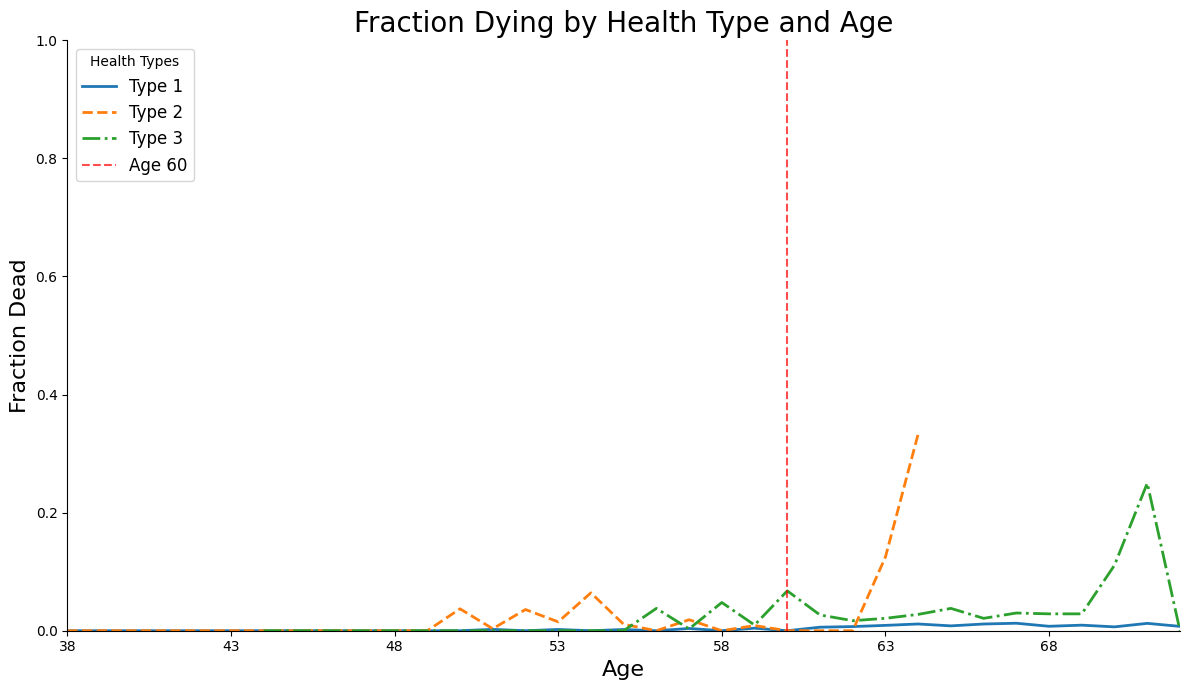

In [143]:
# Create age bins
df_filtered['age_bins'] = pd.cut(df_filtered['age_dv'], bins=range(int(df_filtered['age_dv'].min()), int(df_filtered['age_dv'].max())+2, 1), right=False)

# Calculate fraction dying for each age bin and cluster
death_fraction = df_filtered.groupby(['age_bins', 'Cluster'])['death'].mean().unstack()

# Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

linestyles = ['-', '--', '-.']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # You can adjust these colors

for cluster in range(1, 4):  # Clusters are 1, 2, 3
    cluster_data = death_fraction[cluster].dropna()
    ax.plot(cluster_data.index.map(lambda x: x.left), cluster_data.values,
            label=f'Type {cluster}',
            linestyle=linestyles[cluster-1],
            color=colors[cluster-1],
            linewidth=2)

ax.set_xlabel('Age', fontsize=16)
ax.set_ylabel('Fraction Dead', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a vertical line at age 60
ax.axvline(x=60, color='red', linestyle='--', alpha=0.7, label='Age 60')

ax.set_title('Fraction Dying by Health Type and Age', fontsize=20)
ax.legend(title='Health Types', loc='upper left', fontsize=12)

ax.set_xlim(df_filtered['age_dv'].min(), df_filtered['age_dv'].max())
ax.set_ylim(0, 1)
ax.set_xticks(range(int(df_filtered['age_dv'].min()), int(df_filtered['age_dv'].max())+1, 5))

plt.tight_layout()
plt.show()

### Employment Status

In [64]:
ee_df = pd.read_csv('/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/combined_panel_data.csv')
ee_df.head(5)

,pidp,lf_stat,changejbstat,private,hrgpay,hrnpay,logpay,earnings,education,agghealth,wave
0,22445,1.0,NaN,0.0,6.923610,5.192707,1.934937,1200.000000,2.0,2.0,d
1,22445,1.0,0.0,0.0,9.037906,7.500577,2.201428,1566.449951,2.0,2.0,e
2,22445,1.0,0.0,0.0,14.323737,11.193169,2.661918,2482.590088,2.0,2.0,f
3,22445,1.0,0.0,0.0,16.251269,10.385414,2.788171,2816.669922,2.0,2.0,g
4,22445,1.0,0.0,0.0,16.732056,11.539349,2.817326,2900.000000,2.0,2.0,h


In [66]:
ee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533476 entries, 0 to 533475
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   pidp          533476 non-null  int64  
 1   lf_stat       529884 non-null  float64
 2   changejbstat  428502 non-null  float64
 3   private       243020 non-null  float64
 4   hrgpay        246242 non-null  float64
 5   hrnpay        246242 non-null  float64
 6   logpay        246242 non-null  float64
 7   earnings      242013 non-null  float64
 8   education     525609 non-null  float64
 9   agghealth     532373 non-null  float64
 10  wave          533476 non-null  object 
dtypes: float64(9), int64(1), object(1)
memory usage: 44.8+ MB


In [70]:
# convert several column to integer type first 
ee_df['lf_stat'] = ee_df['lf_stat'].astype('Int64')
ee_df['changejbstat'] = ee_df['changejbstat'].astype('Int64')
ee_df['education'] = ee_df['education'].astype('Int64')
ee_df['agghealth'] = ee_df['agghealth'].astype('Int64')

ee_df.head(3)

,pidp,lf_stat,changejbstat,private,hrgpay,hrnpay,logpay,earnings,education,agghealth,wave
0,22445,1,<NA>,0.0,6.923610,5.192707,1.934937,1200.000000,2,2,d
1,22445,1,0,0.0,9.037906,7.500577,2.201428,1566.449951,2,2,e
2,22445,1,0,0.0,14.323737,11.193169,2.661918,2482.590088,2,2,f


In [71]:
df_frailty['cluster'] = df_frailty['cluster'].astype('Int64')
df_frailty.head(3)

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_94427/961883949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_frailty['cluster'] = df_frailty['cluster'].astype('Int64')


,pidp,wave,age_dv,death,frailty,cluster,death_count
0,22445,d,27.0,0,0.037037,0,0.0
1,22445,e,28.0,0,0.037037,0,0.0
2,22445,f,29.0,0,0.037037,0,0.0


In [104]:
df_frailty.to_csv('/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_clustering.csv', index=False)

In [145]:
# Define the confirmed mapping for lf_stat values
lf_stat_map = {
    1: 'Employed',
    2: 'Unemployed',
    3: 'Inactive'
}

# Merge the datasets
merged_df = pd.merge(ee_df[['pidp', 'lf_stat']], df_filtered[['pidp', 'Cluster']], on='pidp', how='inner')

# Map the lf_stat values to their labels
merged_df['lf_stat_label'] = merged_df['lf_stat'].map(lf_stat_map)

# Create a function to calculate percentages
def calculate_percentages(group):
    return group.value_counts(normalize=True) * 100

# Group by Cluster and lf_stat_label, then calculate percentages
result = merged_df.groupby('Cluster')['lf_stat_label'].apply(calculate_percentages).unstack()

# Ensure all status categories are present, fill with 0 if missing
for status in lf_stat_map.values():
    if status not in result.columns:
        result[status] = 0

# Reorder columns to match the original lf_stat order
result = result[['Employed', 'Unemployed', 'Inactive']]

# Rename columns to add percentage sign
result.columns = [f"{col} (%)" for col in result.columns]

# Reset index to make Cluster a column
result = result.reset_index()

# Round percentages to two decimal places
result = result.round(2)

# Sort by Cluster
result = result.sort_values('Cluster')

# Display the result
print("Employment status distribution by cluster:")
print(result)

# Additional: Calculate overall percentages
overall_percentages = merged_df['lf_stat_label'].value_counts(normalize=True) * 100
print("\nOverall employment status distribution:")
print(overall_percentages.round(2))

Employment status distribution by cluster:
   Cluster  Employed (%)  Unemployed (%)  Inactive (%)
0        1         72.23            3.78         23.99
1        2         37.85            8.63         53.52
2        3         26.89            6.74         66.37

Overall employment status distribution:
lf_stat_label
Employed      68.92
Inactive      26.99
Unemployed     4.10
Name: proportion, dtype: float64


/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_94427/1552425116.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = merged_df.groupby(['age_bins', 'Cluster']).apply(lambda x: (x['lf_stat'] == 1).mean() * 100).unstack()
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_94427/1552425116.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  binned_data = merged_df.groupby(['age_bins', 'Cluster']).apply(lambda x: (x['lf_stat'] == 1).mean() * 100).unstack()


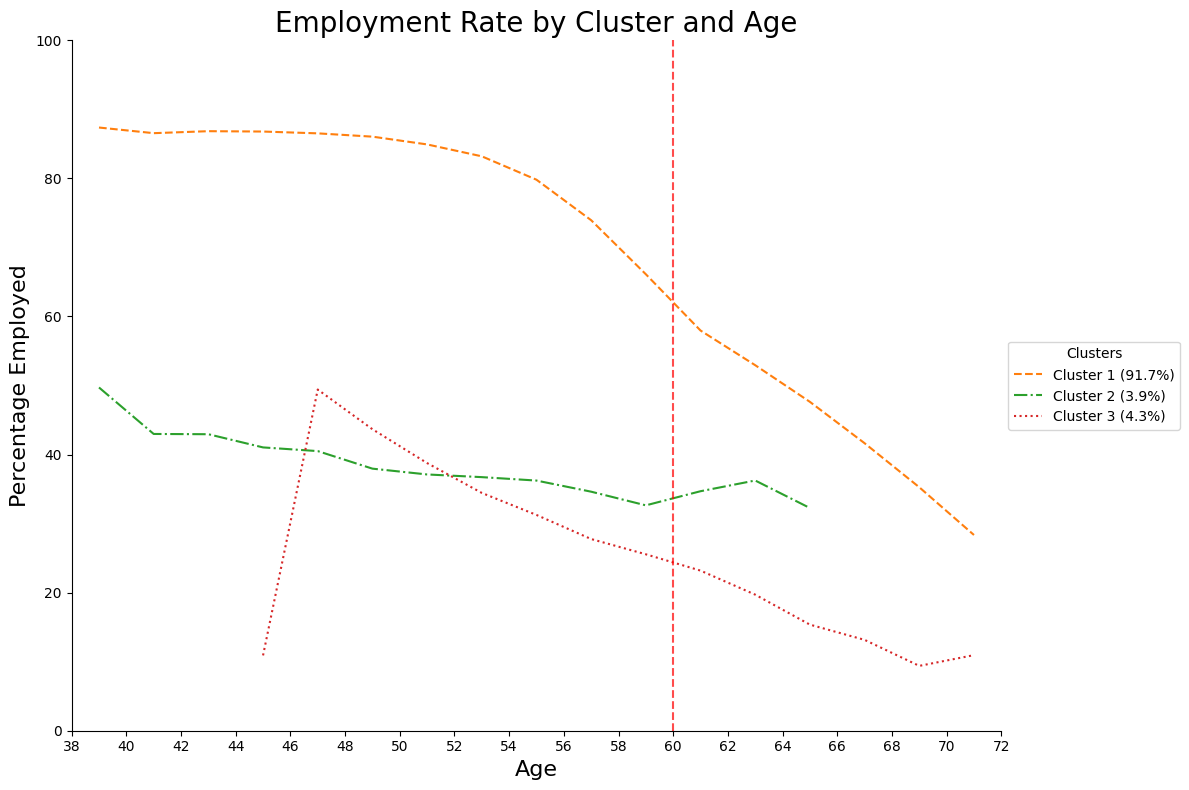

In [147]:
# Assuming ee_df contains 'pidp' and 'lf_stat'
# Assuming df_filtered contains 'pidp', 'Cluster', and 'age_dv'

# Merge the lf_stat from ee_df into df_filtered
merged_df = pd.merge(df_filtered, ee_df[['pidp', 'lf_stat']], on='pidp', how='left')

# Filter the data
merged_df = merged_df[(merged_df['age_dv'] >= 38) & (merged_df['age_dv'] <= 72)]

# Create age bins
merged_df['age_bins'] = pd.cut(merged_df['age_dv'], bins=range(38, 73, 2), right=False)

# Calculate the percentage of employed individuals for each bin and cluster
binned_data = merged_df.groupby(['age_bins', 'Cluster']).apply(lambda x: (x['lf_stat'] == 1).mean() * 100).unstack()

# Calculate the percentage of individuals in each cluster
cluster_percentages = merged_df['Cluster'].value_counts(normalize=True) * 100

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

linestyles = ['-', '--', '-.', ':']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for cluster in binned_data.columns:
    cluster_data = binned_data[cluster].dropna()
    ax.plot(cluster_data.index.map(lambda x: x.mid), cluster_data.values,
            label=f'Cluster {cluster} ({cluster_percentages[cluster]:.1f}%)',
            linestyle=linestyles[cluster % len(linestyles)],
            color=colors[cluster % len(colors)])

ax.set_xlabel('Age', fontsize=16)
ax.set_ylabel('Percentage Employed', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a vertical line at age 60
ax.axvline(x=60, color='red', linestyle='--', alpha=0.7)

ax.set_title('Employment Rate by Cluster and Age', fontsize=20)
ax.legend(title='Clusters', loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlim(38, 72)
ax.set_ylim(0, 100)
ax.set_xticks(range(38, 73, 2))

plt.tight_layout()
plt.show()

### Earning Status by Cluster

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_94427/3281411853.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = merged_df.groupby(['age_bins', 'Cluster'])['hrgpay'].mean().unstack()


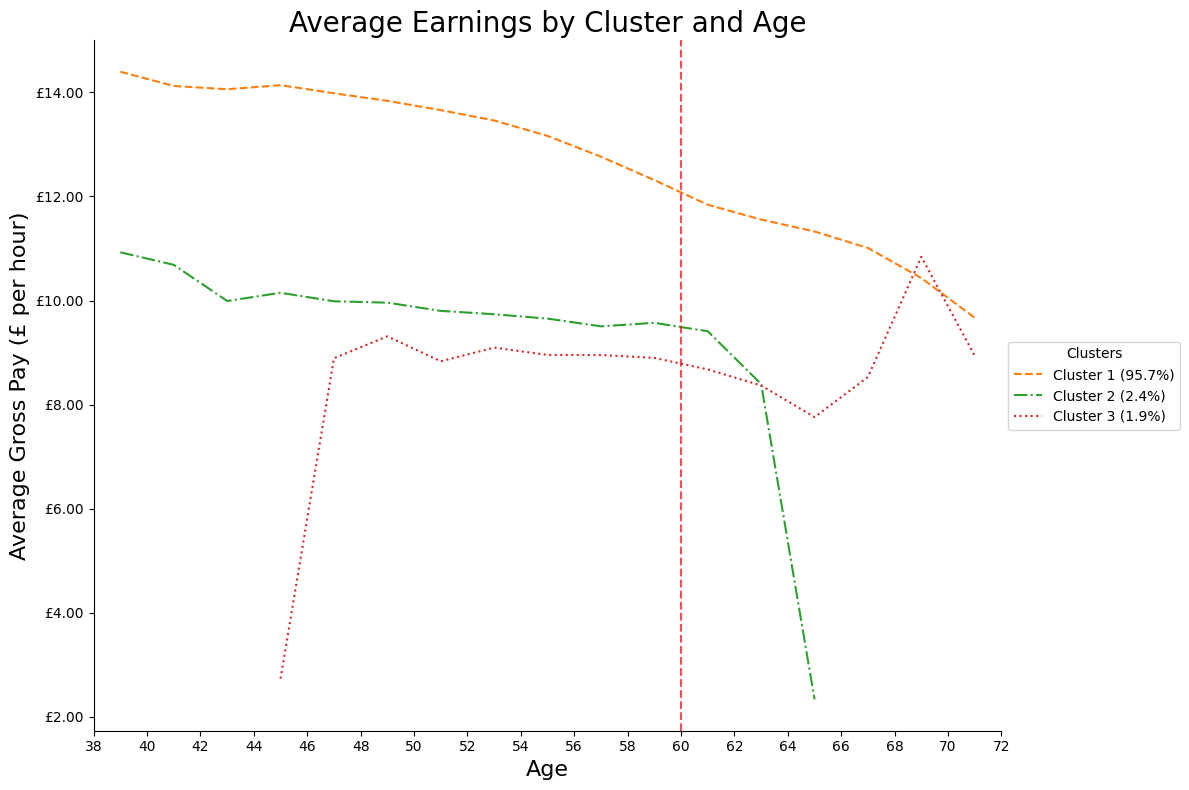

Overall average gross pay per hour: £12.95
Average gross pay per hour for Cluster 1: £13.11
Average gross pay per hour for Cluster 3: £8.86
Average gross pay per hour for Cluster 2: £9.84


In [150]:
# Merge the earnings data with the frailty data
merged_df = pd.merge(ee_df[['pidp', 'hrgpay']], df_filtered[['pidp', 'Cluster', 'age_dv']], on='pidp', how='inner')

# Filter the data
merged_df = merged_df[(merged_df['age_dv'] >= 38) & (merged_df['age_dv'] <= 72) & 
                      (~np.isnan(merged_df['Cluster'])) & (~np.isnan(merged_df['hrgpay']))]

# Create age bins
merged_df['age_bins'] = pd.cut(merged_df['age_dv'], bins=range(38, 73, 2), right=False)

# Calculate the average earnings for each bin and cluster
binned_data = merged_df.groupby(['age_bins', 'Cluster'])['hrgpay'].mean().unstack()

# Calculate the percentage of individuals in each cluster
cluster_percentages = merged_df['Cluster'].value_counts(normalize=True) * 100

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

linestyles = ['-', '--', '-.', ':']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for cluster in binned_data.columns:
    cluster_data = binned_data[cluster].dropna()
    ax.plot(cluster_data.index.map(lambda x: x.mid), cluster_data.values,
            label=f'Cluster {cluster} ({cluster_percentages[cluster]:.1f}%)',
            linestyle=linestyles[cluster % len(linestyles)],
            color=colors[cluster % len(colors)])

ax.set_xlabel('Age', fontsize=16)
ax.set_ylabel('Average Gross Pay (£ per hour)', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a vertical line at age 60
ax.axvline(x=60, color='red', linestyle='--', alpha=0.7)

ax.set_title('Average Earnings by Cluster and Age', fontsize=20)
ax.legend(title='Clusters', loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlim(38, 72)
ax.set_xticks(range(38, 73, 2))

# Format y-axis as currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x:.2f}'))

plt.tight_layout()
plt.show()

# Print some summary statistics
print(f"Overall average gross pay per hour: £{merged_df['hrgpay'].mean():.2f}")
for cluster in merged_df['Cluster'].unique():
    cluster_avg = merged_df[merged_df['Cluster'] == cluster]['hrgpay'].mean()
    print(f"Average gross pay per hour for Cluster {cluster}: £{cluster_avg:.2f}")

#### Mean Gross Pay with Bootstrapped Confidence Interval

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_94427/1036668051.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = merged_df.groupby(['age_bins', 'Cluster'])['hrgpay'].apply(mean_confidence_interval).unstack()


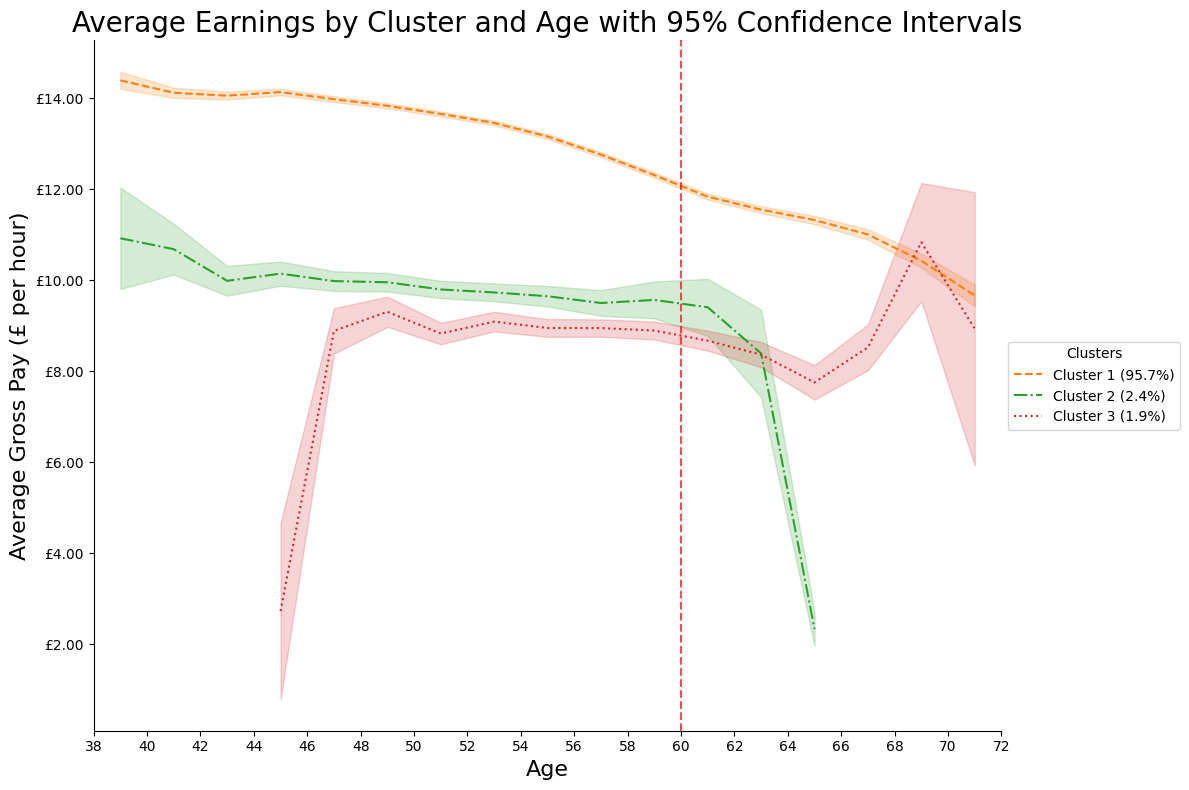

Overall average gross pay per hour: £12.95
Average gross pay per hour for Cluster 1: £13.11
Average gross pay per hour for Cluster 3: £8.86
Average gross pay per hour for Cluster 2: £9.84


In [151]:
# Assuming merged_df is already created with ee_df and df_filtered merged

# Filter the data
merged_df = merged_df[(merged_df['age_dv'] >= 38) & (merged_df['age_dv'] <= 72) & 
                      (~np.isnan(merged_df['Cluster'])) & (~np.isnan(merged_df['hrgpay']))]

# Create age bins
merged_df['age_bins'] = pd.cut(merged_df['age_dv'], bins=range(38, 73, 2), right=False)

# Function to calculate mean and confidence interval
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

# Calculate the average earnings and confidence intervals for each bin and cluster
binned_data = merged_df.groupby(['age_bins', 'Cluster'])['hrgpay'].apply(mean_confidence_interval).unstack()

# Calculate the midpoint of each age bin for plotting
binned_data.index = binned_data.index.map(lambda x: x.mid)

# Calculate the percentage of individuals in each cluster
cluster_percentages = merged_df['Cluster'].value_counts(normalize=True) * 100

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

linestyles = ['-', '--', '-.', ':']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for cluster in binned_data.columns:
    cluster_data = binned_data[cluster].dropna()
    x = cluster_data.index
    y = cluster_data.apply(lambda x: x[0])
    ci_low = cluster_data.apply(lambda x: x[1])
    ci_high = cluster_data.apply(lambda x: x[2])
    
    ax.fill_between(x, ci_low, ci_high, alpha=0.2, color=colors[cluster % len(colors)])
    ax.plot(x, y, label=f'Cluster {cluster} ({cluster_percentages[cluster]:.1f}%)',
            linestyle=linestyles[cluster % len(linestyles)],
            color=colors[cluster % len(colors)])

ax.set_xlabel('Age', fontsize=16)
ax.set_ylabel('Average Gross Pay (£ per hour)', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add a vertical line at age 60
ax.axvline(x=60, color='red', linestyle='--', alpha=0.7)

ax.set_title('Average Earnings by Cluster and Age with 95% Confidence Intervals', fontsize=20)
ax.legend(title='Clusters', loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlim(38, 72)
ax.set_xticks(range(38, 73, 2))

# Format y-axis as currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'£{x:.2f}'))

plt.tight_layout()
plt.show()

# Print some summary statistics
print(f"Overall average gross pay per hour: £{merged_df['hrgpay'].mean():.2f}")
for cluster in merged_df['Cluster'].unique():
    cluster_avg = merged_df[merged_df['Cluster'] == cluster]['hrgpay'].mean()
    print(f"Average gross pay per hour for Cluster {cluster}: £{cluster_avg:.2f}")

### Highest level of Education Attained by Cluster

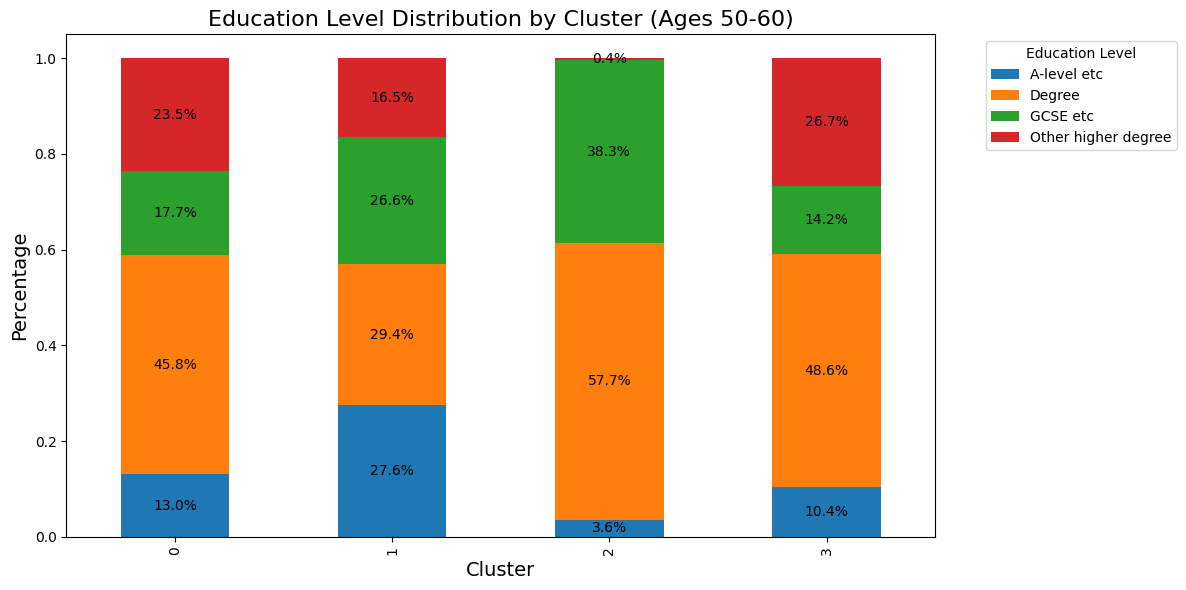

Education distribution by cluster:
education  A-level etc  Degree  GCSE etc  Other higher degree
cluster                                                      
0                 0.13    0.46      0.18                 0.24
1                 0.28    0.29      0.27                 0.16
2                 0.04    0.58      0.38                 0.00
3                 0.10    0.49      0.14                 0.27

Chi-square test for independence between cluster and education:
Chi-square statistic: 1213.84
p-value: 0.0000

Number of individuals in each cluster:
cluster
0    1857
1    9158
2     996
3    1193
Name: count, dtype: Int64

Percentage of individuals in each cluster:
cluster
0    14.1
1    69.4
2     7.5
3     9.0
Name: count, dtype: Float64


In [91]:
# Merge the education data with the frailty data
merged_df = pd.merge(ee_df[['pidp', 'education']], df_frailty[['pidp', 'cluster', 'age_dv']], on='pidp', how='inner')

# Filter the data for relevant education levels and age range (50-60)
education_map = {
    1: 'Degree', 
    2: 'Other higher degree',
    3: 'A-level etc',
    4: 'GCSE etc'
}
merged_df = merged_df[(merged_df['education'].isin(education_map.keys())) & 
                      (merged_df['age_dv'] >= 50) & (merged_df['age_dv'] <= 60)]
merged_df['education'] = merged_df['education'].map(education_map)

# Calculate percentages for cluster distribution
cluster_dist = merged_df.groupby('cluster')['education'].value_counts(normalize=True).unstack()

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

cluster_dist.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Education Level Distribution by Cluster (Ages 50-60)', fontsize=16)
ax.set_xlabel('Cluster', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.legend(title='Education Level', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels on the bars
for c in ax.containers:
    labels = [f'{v.get_height():.1%}' if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print summary statistics
print("Education distribution by cluster:")
print(cluster_dist.round(2))

# Chi-square test of independence
from scipy.stats import chi2_contingency

cluster_edu_crosstab = pd.crosstab(merged_df['cluster'], merged_df['education'])
chi2, p_value, dof, expected = chi2_contingency(cluster_edu_crosstab)
print(f"\nChi-square test for independence between cluster and education:")
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.4f}")

# Calculate and print the total number of individuals in each cluster
cluster_sizes = merged_df['cluster'].value_counts().sort_index()
print("\nNumber of individuals in each cluster:")
print(cluster_sizes)
print("\nPercentage of individuals in each cluster:")
print((cluster_sizes / cluster_sizes.sum() * 100).round(1))